In [ ]:
# global imports 
import os 
import pandas as pd

from pathlib import Path
path = Path(os.getcwd())
HOME_PATH = str(path.parent)

from pyspark.sql import SparkSession

In [2]:
import pandas as pd
# needed import
bbc_text_df = pd.read_csv(HOME_PATH+'/data/bbc-text.csv')
bbc_text_df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


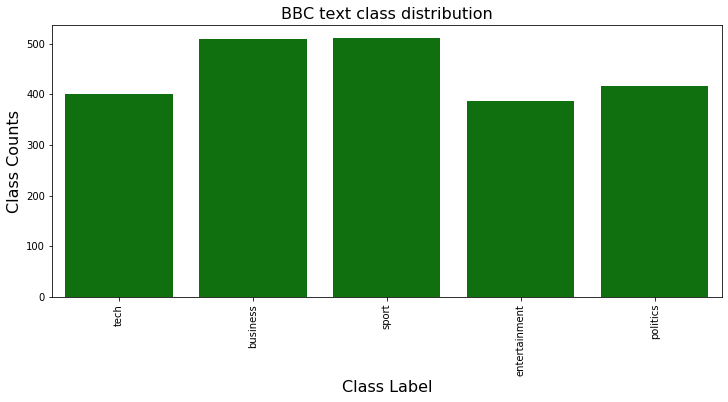

In [3]:
# Plot a graph to see how many news we ve got per category in order to see the distribution of our dataset 
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.countplot(x=bbc_text_df.category, color='green')
plt.title('BBC text class distribution', fontsize=16)
plt.ylabel('Class Counts', fontsize=16)
plt.xlabel('Class Label', fontsize=16)
plt.xticks(rotation='vertical');

##### Data Preprocessing
- convert all to lower case
- Removing ponctuations marks
- remove extra spaces 
- remove tags
- remove stop words (and to or the)
- Stemming

In [7]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [8]:
clean_text(bbc_text_df.iloc[2,1])

'tiger wari farrel gambl leicest rush make bid andi farrel great britain rugbi leagu captain decid switch code anybodi involv process wai awai go stage tiger boss john well told bbc radio leicest moment lot unknown andi farrel medic situat go big big gambl farrel persist knee problem oper knee week ago expect month leicest saracen believ head list rugbi union club interest sign farrel decid man game union well believ better plai back initi sure step leagu union involv centr said well think england prefer progress posit row us rugbi leagu skill forward juri cross divid club balanc struck cost gambl option bring readi replac'

### Now let the fun begin
#### making cloud word


In [11]:
df_x = bbc_text_df['text']
df_y = bbc_text_df['category']

In [12]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(clean_text(row).split(), [index]) for index, row in enumerate(df_x)]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(clean_text(row).split())
for index, row in enumerate(df_x)]))

## DOC2VEC


In [13]:
doc2vec_trf = Doc2VecTransformer()
doc2vec_features = doc2vec_trf.fit(df_x).transform(df_x)
doc2vec_features

100%|██████████| 2225/2225 [00:00<00:00, 3399754.61it/s]


matrix([[ 7.6177724e-02, -2.4943294e-01,  1.4069784e-01, ...,
         -2.6775798e-01,  1.3201460e-01,  1.4781544e-01],
        [ 2.0848238e-04,  1.1448180e-02, -3.0812123e-03, ...,
          1.1818735e-02, -3.8386376e-03, -3.7918771e-03],
        [-4.6487321e-04,  9.6855446e-04, -5.6323200e-03, ...,
         -1.5802367e-04,  5.8328774e-04, -3.3406628e-04],
        ...,
        [ 3.3242237e-03,  5.6827045e-03, -7.5396658e-03, ...,
          4.7206362e-03, -5.0453618e-03, -7.5985170e-03],
        [ 1.4175060e-01, -4.1123202e-01,  2.2547348e-01, ...,
         -4.5718929e-01,  2.2481333e-01,  2.0202561e-01],
        [ 2.1492026e-03,  1.7348600e-03,  2.6163857e-03, ...,
          5.1888041e-03,  3.7702655e-03, -5.6438206e-04]], dtype=float32)

In [14]:
# Logistic regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

pl_log_reg = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                             ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Logistic Regression: ', scores.mean())

100%|██████████| 1781/1781 [00:00<00:00, 2425342.67it/s]
/opt/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
100%|██████████| 1781/1781 [00:00<00:00, 3070306.38it/s]
/opt/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
100%|██████████| 1781/1781 [00:00<00:00, 3077896.75it/s]
/opt/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy for Logistic Regression:  0.3708413590155163


In [15]:
# Random forest
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

pl_log_reg = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                             ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Logistic Regression: ', scores.mean())

100%|██████████| 1781/1781 [00:00<00:00, 3163937.07it/s]
/opt/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
100%|██████████| 1781/1781 [00:00<00:00, 3058990.76it/s]
/opt/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy for Logistic Regression:  0.3762526752273943


In [16]:
# XGBoost
import xgboost as xgb

pl_xgb = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb, df_x, df_y, cv=5)
print('Accuracy for XGBoost Classifier : ', scores.mean())

100%|██████████| 1781/1781 [00:00<00:00, 2652718.55it/s]


Accuracy for XGBoost Classifier :  0.3604809986551559


#### TF-IDF

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

class Text2TfIdfTransformer(BaseEstimator):

    def __init__(self):
        self._model = TfidfVectorizer()
        pass

    def fit(self, df_x, df_y=None):
        df_x = df_x.apply(lambda x : clean_text(x))
        self._model.fit(df_x)
        return self

    def transform(self, df_x):
        return self._model.transform(df_x)

In [19]:
tfidf_transformer = Text2TfIdfTransformer()
tfidf_vectors = tfidf_transformer.fit(df_x).transform(df_x)

In [20]:
tfidf_vectors.shape

(2225, 18754)

In [21]:
print(tfidf_vectors)

  (0, 18656)	0.026751783070208267
  (0, 18461)	0.012282569403139645
  (0, 18330)	0.06321612895581909
  (0, 18304)	0.1583605258104538
  (0, 18174)	0.03191861694040893
  (0, 18106)	0.07347900571034054
  (0, 18077)	0.0820082845034905
  (0, 18027)	0.08634135472606572
  (0, 17846)	0.024976845920106364
  (0, 17835)	0.03920692490243918
  (0, 17819)	0.0237112847547106
  (0, 17635)	0.10369692742506256
  (0, 17586)	0.058415007300576784
  (0, 17171)	0.42378247529420265
  (0, 17022)	0.04909762905009908
  (0, 16860)	0.024467110895914575
  (0, 16826)	0.012395674298416093
  (0, 16801)	0.04354600077310887
  (0, 16800)	0.1061221922410514
  (0, 16759)	0.019836834312179287
  (0, 16756)	0.02454881452504954
  (0, 16637)	0.108042004704681
  (0, 16625)	0.3048220054117621
  (0, 16528)	0.02112249983533661
  (0, 16356)	0.030876741901122738
  :	:
  (2224, 8118)	0.5554941760150036
  (2224, 8007)	0.10226374007302491
  (2224, 7455)	0.11194511747688254
  (2224, 7426)	0.0589324755687766
  (2224, 7372)	0.0462288710188

In [22]:
# Logitisic Regression
pl_log_reg_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                             ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg_tf_idf, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & Logistic Regression: ', scores.mean())

/opt/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy for Tf-Idf & Logistic Regression:  0.8966269268867583


/opt/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [30]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
pl_random_forest_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                                   ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest_tf_idf, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & RandomForest : ', scores.mean())

/opt/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy for Tf-Idf & RandomForest :  0.8619956202189348


/opt/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [27]:
pl_xgb_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb_tf_idf, df_x, df_y, cv=5)
print('Accuracy for Tf-Idf & XGBoost Classifier : ', scores.mean())

Accuracy for Tf-Idf & XGBoost Classifier :  0.933037928578659


# conclusion
now we came to the end of this notebook, we have seen that the DOC2VEC didnt give good result altough its more sofisticated and this is caused by the nature of our data which is spread Gramatically.
the TF-IDF was our best approach using XGBoost Classifier and gave us 93.3% accurancy  